In [1]:
import sys
sys.path.append('../../../code/')
sys.path.append('../../../code/michael')
import os
import json
from datetime import datetime
import time
from pipeline.download_data import url_to_dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import networkx as nx
from load_data import load_citation_network, case_info
import operator
from operator import itemgetter
import scotus_viz_functions_michael as viz

from collections import OrderedDict


%load_ext autoreload
%autoreload 2
%matplotlib inline

data_dir = '../../../data/'
court_name = 'scotus'

# assign/make 'scotus_visualizations/michael' directory to save files in
proj_cwd = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
viz_dir = os.path.join(proj_cwd, 'visualization')
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)
viz_scotus_dir = os.path.join(viz_dir, 'scotus')
if not os.path.exists(viz_scotus_dir):
    os.makedirs(viz_scotus_dir)
viz_scotus_michael_dir = os.path.join(viz_scotus_dir, 'michael')
if not os.path.exists(viz_scotus_michael_dir):
    os.makedirs(viz_scotus_michael_dir)
 
csvs_dir = os.getcwd() + '/csvs'
plots_dir = os.getcwd() + '/plots'

### Create SCOTUS Network (Directed)

In [2]:
# this will be a little slow the first time you run it

time1 = time.time()
G = load_citation_network(data_dir, court_name)
time2 = time.time()

print 'loading scotus network in networkx took %d seconds' % (time2-time1)
print 'loaded %s network with %d cases and %d edges' % (court_name, len(G.nodes()), len(G.edges()))

loading scotus network in networkx took 23 seconds
loaded scotus network with 33248 cases and 250465 edges


### Remove Case 96405

In [3]:
G.remove_node(96405)

### SCOTUS Network by Date vs. Betweenness Centrality 
##### highlighted node = 'interesting_node'

--- 185.817000151 seconds ---


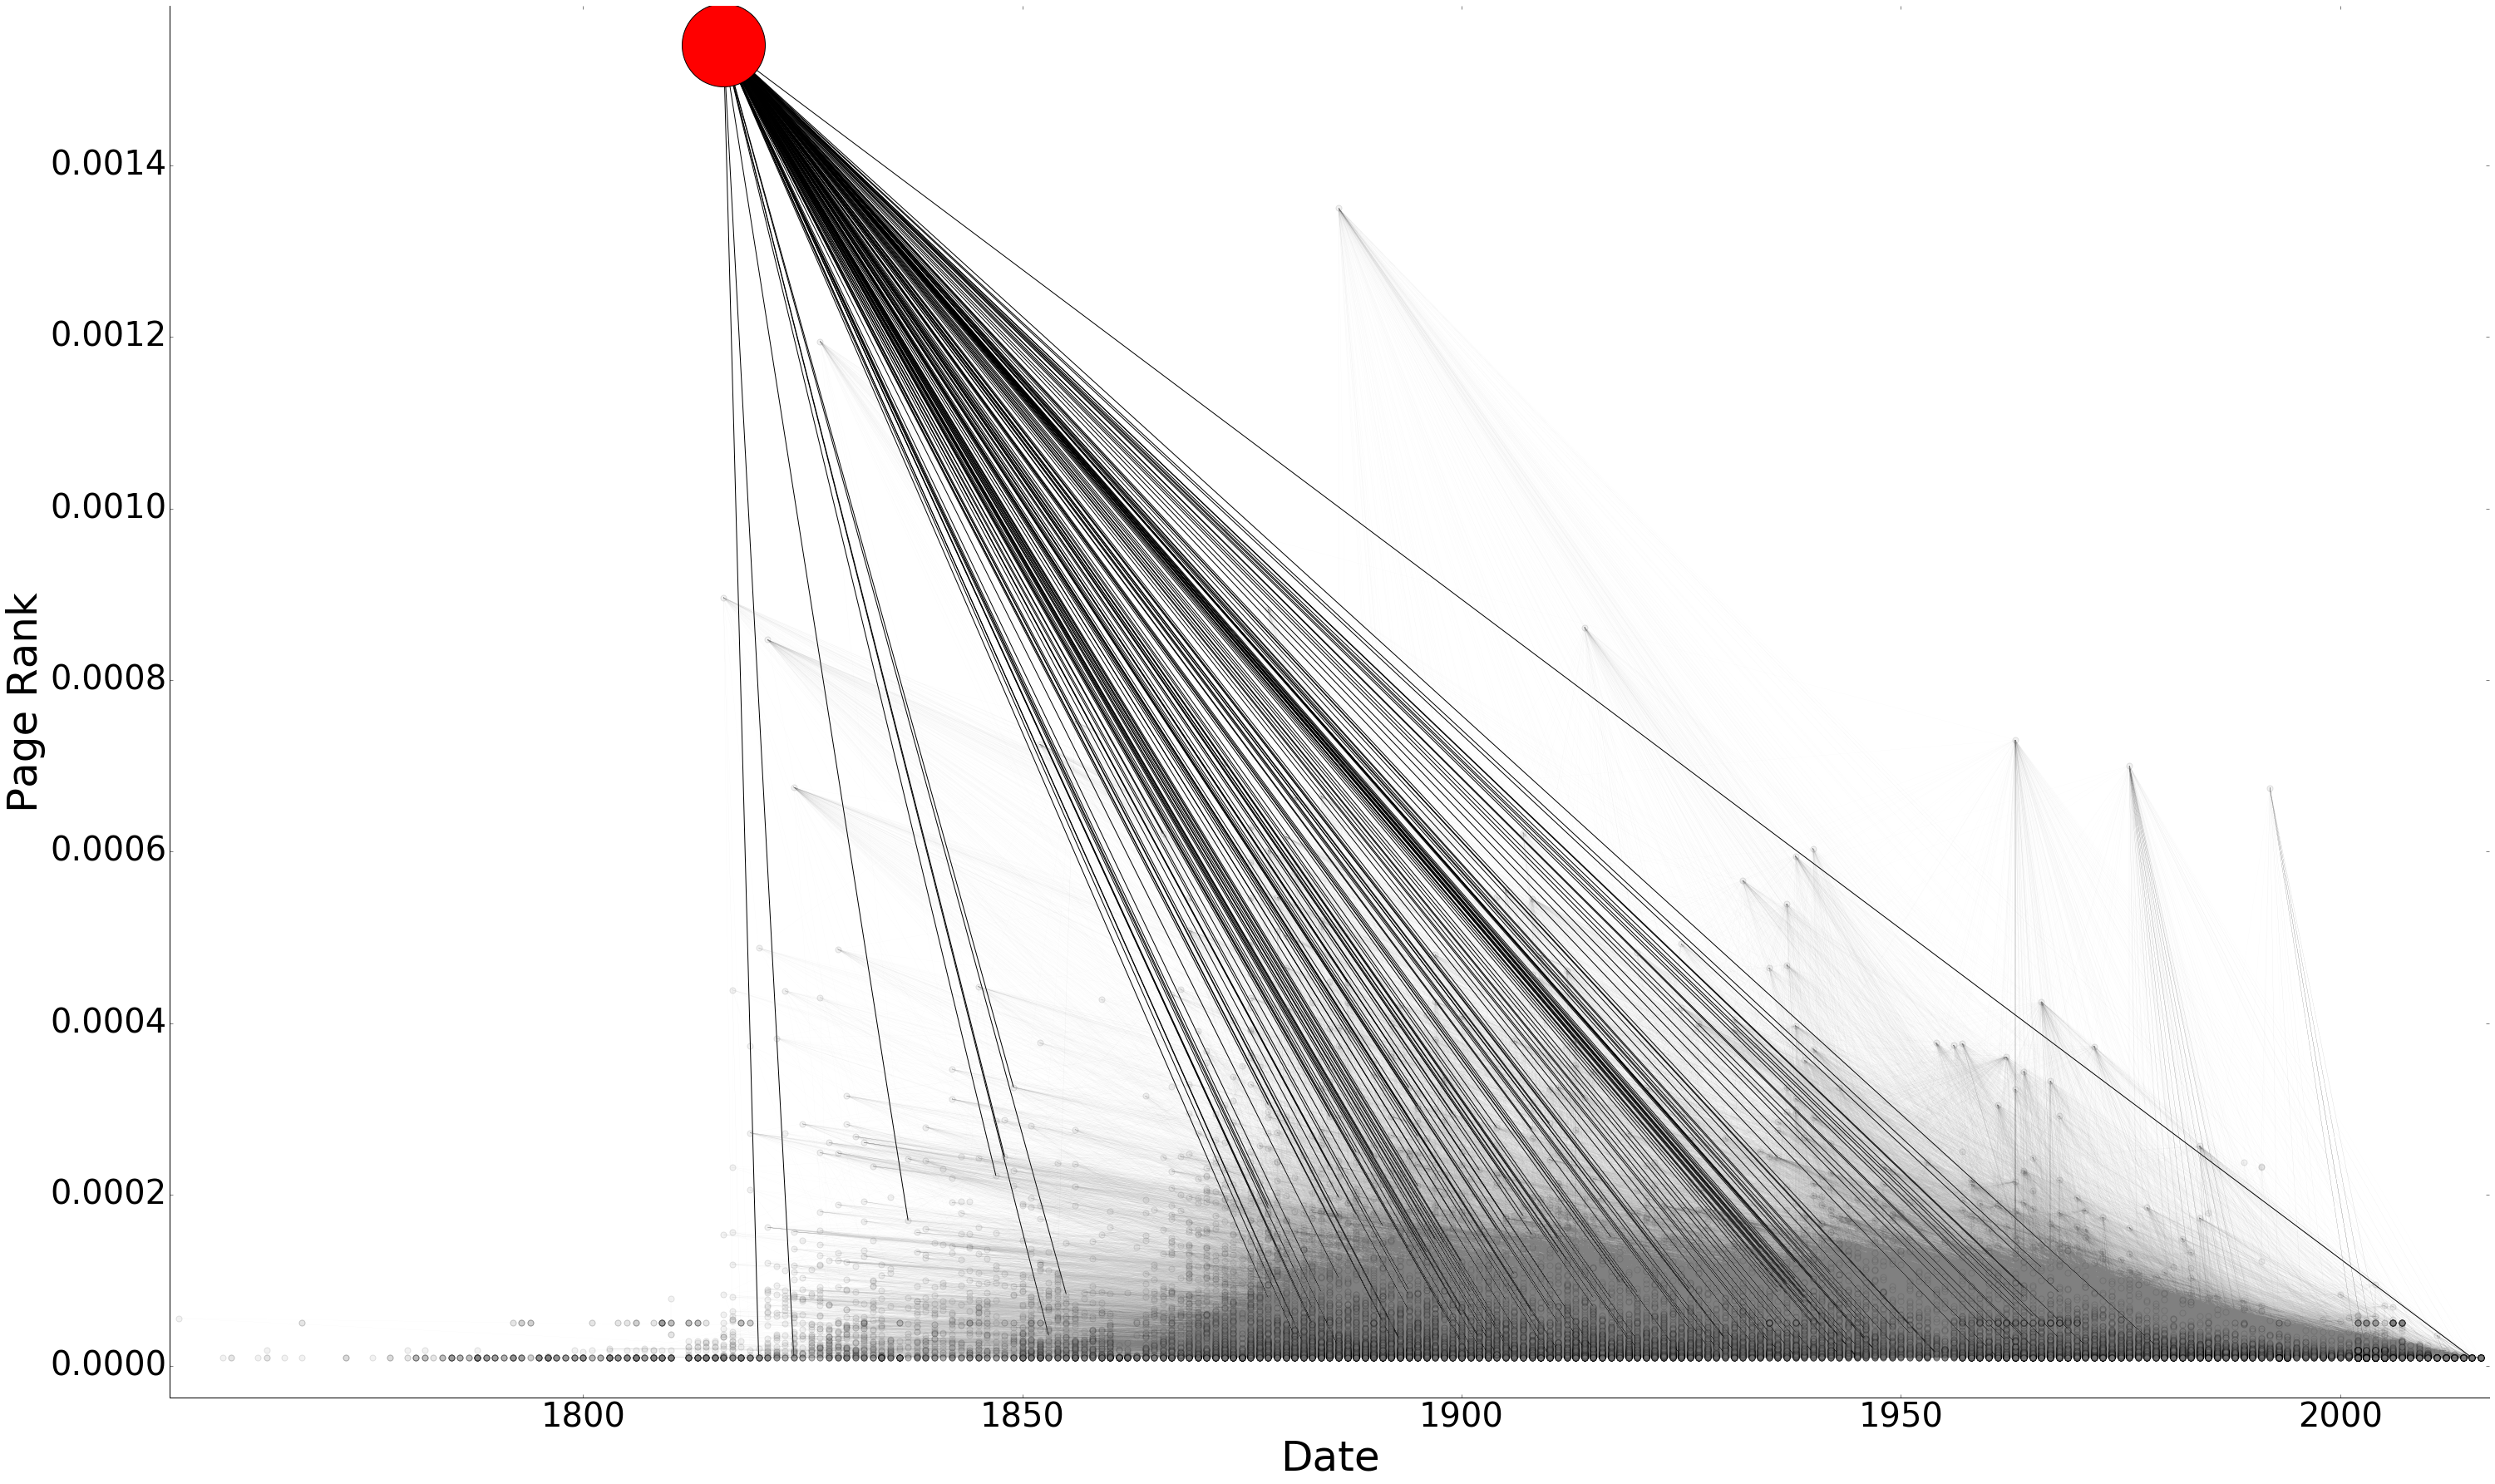

In [11]:
def chronological_layout_centrality(graph_object, centrality_type, save_dir):
    '''
    USAGE: chronological_layout_centrality(D, 'closeness_centrality', 'some_directory/plot_test.png')

    centrality_type: (String)
        - 'closeness_centrality'
        - 'eigenvector_centrality'
        - 'betweenness_centrality'
        - 'hubs'
        - 'authorities'
        - 'page_rank'
    '''
    
    start_time = time.time() # start timer to approximate how long this function takes

    ###############
    # Make Graph G
    ###############
    G = graph_object

    # Get Date Attribute for G.nodes()
    dates = []
    cases_without_dates = []
    for each_node in G.nodes():
        if G.node[each_node]['date'] == '':
            cases_without_dates.append(each_node)
        else:
            dates.append(G.node[each_node]['date'])

    # Get Title
    title = ' SCOTUS Network with ' + str(G.number_of_nodes()) + ' Cases'

    ##################################
    # For Coloring by Centrality Later
    ##################################
    if centrality_type == 'closeness_centrality':
        undirected_scotus_csv = pd.read_csv(csvs_dir + '/undirected_scotus_centralities_96405_del.csv')
        case_id_list = undirected_scotus_csv['Case ID'].tolist()
        close_cent_list = undirected_scotus_csv['Closeness Centrality'].tolist()
        pair = zip(case_id_list, close_cent_list)
        n_color_G = close_cent_list
        
        ccd = sorted(pair, key = operator.itemgetter(1), reverse=True)[:1]
        interesting_node = [x[0] for x in ccd]
        #interesting_node = [101864]
        others_nodelist = [i for i in graph_object.nodes() if i not in interesting_node]
        
        top_edgelist = graph_object.edges(interesting_node)
        others_edgelist = [i for i in graph_object.edges() if i not in top_edgelist]
    
    if centrality_type == 'page_rank':
        directed_scotus_csv = pd.read_csv(csvs_dir + '/directed_scotus_centralities_96405_del.csv')
        case_id_list = directed_scotus_csv['Case ID'].tolist()
        page_rank_list = directed_scotus_csv['Page Rank'].tolist()
        pair = zip(case_id_list, page_rank_list)
        n_color_G = page_rank_list
        
        prd = sorted(pair, key = operator.itemgetter(1), reverse=True)[:1]
        interesting_node = [x[0] for x in prd]
        #interesting_node = [101864]
        others_nodelist = [i for i in graph_object.nodes() if i not in interesting_node]
        
        top_edgelist = graph_object.to_undirected().edges(interesting_node)
        others_edgelist = [i for i in graph_object.to_undirected().edges() if i not in top_edgelist]
    
    ####################################################
    # Get X- and Y- Coordinates for Chronological Layout
    ####################################################
    ### X-Coordinates for each node in network:

    # X-Coordinates are YEAR VALUES (i.e. 1986 June 16th = 1989.458333...)
    X_G = []
    for specific_date in dates:
        temp_year, temp_month, temp_day = ['','',''] if specific_date is '' else [int(element) for element in specific_date.rsplit('-')]
        total_months = 12
        if temp_month == 1 or 3 or 5 or 7 or 8 or 10 or 12:
            total_days = 31
        elif temp_month == 4 or 6 or 9 or 11:
            total_days = 30
        else: #temp_month = 2
            if calendar.isleap(temp_year):
                total_days = 29
            else: # it isn't leap year
                total_days = 28
        date_to_int = temp_year + (temp_month-1)/total_months + (temp_day-1)/(total_months * total_days)
        X_G.append(date_to_int)

    ### Y-Coordinates for each node in network:

    # Y-Coordinates are the respective centrality of each node:
    #Y_G = n_color_G
    if centrality_type == 'closeness_centrality':
        undirected_scotus_csv = pd.read_csv(csvs_dir + '/undirected_scotus_centralities_96405_del.csv')
        close_cent_list = undirected_scotus_csv['Closeness Centrality'].tolist()
        Y_G = close_cent_list
    if centrality_type == 'page_rank':
        directed_scotus_csv = pd.read_csv(csvs_dir + '/directed_scotus_centralities_96405_del.csv')
        page_rank_list = directed_scotus_csv['Page Rank'].tolist()
        Y_G = page_rank_list

    ### make list of tuples of (x,y) coordinates for respective nodes: [(x1,y1), (x2,y2), ... , (xn,yn)]:
    list_of_tuples_G = zip(X_G, Y_G)

    ###############################################################################
    # Draw Network with Chronological Layout and Colored Nodes by centrality values
    ###############################################################################
    '''
    Note: Ill-Advised to Change Around sizes/scaling/margins/etc. of plot, unless otherwise stated
    '''

    # figure size adjust, figure title
    fig = plt.figure()
    fig.set_size_inches(50, 30)
    #fig.suptitle(title, fontsize=50)

    # draw network
    pre_pos_G = dict(zip(G.nodes(), list_of_tuples_G)) # make a dictionary and assign each node its coordinate point
    pos_G = nx.spring_layout(G, fixed = G.nodes(), pos = pre_pos_G) # you have to fix the nodes in place!
    #nx.draw_networkx(G, pos = pos_G, node_size=50, arrows=False, with_labels=False, node_color=n_color_G, cmap=plt.cm.Blues, edge_color='black', width=1.0/10, style='solid')
    
    #nx.draw_networkx_nodes(G, pos=pos_G, node_color='red', nodelist=interesting_node, node_size=10000)
    #nx.draw_networkx_nodes(G, pos=pos_G, node_color='white', nodelist=others_nodelist, node_size=50)
    #nx.draw_networkx_edges(G, pos=pos_G, edge_color='black', arrows=False, width=1.0/10)
    
    nx.draw_networkx_nodes(G, pos=pos_G, node_color='red', nodelist=interesting_node, node_size=10000)
    nx.draw_networkx_nodes(G, pos=pos_G, node_color='grey', nodelist=others_nodelist, node_size=50, alpha=0.1)
    
    nx.draw_networkx_edges(G, pos=pos_G, edge_color='black', arrows=False, edgelist=top_edgelist, width=1.0)
    nx.draw_networkx_edges(G, pos=pos_G, edge_color='grey', arrows=False, edgelist=others_edgelist, width=1.0/10, alpha=0.1)
    
    '''
    Note: you can...
        1. turn on arrows (although not really necessary, since you know nodes at right are citing the nodes at left)
        2. change the coloring of nodes--i.e. cmap = plt.cm.Reds
    * Other characteristics are optimized for visualization purposes in the author's humble opinion, but feel free to change for experimentation
    '''

    # add xlabel, remove ylabel, set x-margin, set y-margin, set x-ticks
    plt.xlabel("Date", fontsize=50)
    if centrality_type == 'closeness_centrality':
        plt.ylabel('Closeness Centrality', fontsize=50)
    if centrality_type == 'page_rank':
        plt.ylabel('Page Rank', fontsize=50)
    axes = plt.gca()
    axes.set_xlim([min(X_G)-1, max(X_G)+1])
    axes.set_ylim([min(Y_G)-0.03*max(Y_G), max(Y_G)+0.03*max(Y_G)])
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.savefig(save_dir)

    print("--- %s seconds ---" % (time.time() - start_time)) # end timer to approximate how long it takes to plot/draw the network
    
chronological_layout_centrality(G, 'page_rank', plots_dir + '/page_rank_network_highlighted.png')